<a href="https://colab.research.google.com/github/olatowojujoshua/Canada_COVID_Hospital_Burden/blob/main/Project_A_Canada_COVID_Hospital_Burden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **data import**

In [1]:
import pandas as pd

COVID_CSV_URL = "https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv"

df = pd.read_csv(COVID_CSV_URL)

df.head()


,pruid,prname,prnameFR,date,reporting_week,reporting_year,update,totalcases,numtotal_last7,ratecases_total,...,ratecases_last7,ratedeaths_last7,numtotal_last14,numdeaths_last14,ratetotal_last14,ratedeaths_last14,avgcases_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7
0,59,British Columbia,Colombie-Britannique,2020-02-08,6,2020,1.0,4,3,0.07,...,0.05,0.0,4,0.0,0.07,0.0,0.43,0.01,0.0,0.0
1,48,Alberta,Alberta,2020-02-08,6,2020,1.0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0
2,47,Saskatchewan,Saskatchewan,2020-02-08,6,2020,1.0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0
3,46,Manitoba,Manitoba,2020-02-08,6,2020,1.0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0
4,35,Ontario,Ontario,2020-02-08,6,2020,1.0,4,1,0.03,...,0.01,0.0,1,0.0,0.01,0.0,0.14,0,0.0,0.0


In [2]:
df.columns


Index(['pruid', 'prname', 'prnameFR', 'date', 'reporting_week',
       'reporting_year', 'update', 'totalcases', 'numtotal_last7',
       'ratecases_total', 'numdeaths', 'numdeaths_last7', 'ratedeaths',
       'ratecases_last7', 'ratedeaths_last7', 'numtotal_last14',
       'numdeaths_last14', 'ratetotal_last14', 'ratedeaths_last14',
       'avgcases_last7', 'avgincidence_last7', 'avgdeaths_last7',
       'avgratedeaths_last7'],
      dtype='object')

# **CLEAN + PREPARE DATA**

In [3]:
df_clean = df.copy()

# Convert date
df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")

# Keep only needed columns
df_clean = df_clean[[
    "pruid", "prname", "date",
    "totalcases", "numtotal_last7", "numtotal_last14",
    "ratecases_total", "ratecases_last7",
    "numdeaths", "numdeaths_last7", "numdeaths_last14",
    "ratedeaths", "ratedeaths_last7"
]]

# Remove national summary row ("Canada")
df_clean = df_clean[df_clean["prname"] != "Canada"]

df_clean.head()


,pruid,prname,date,totalcases,numtotal_last7,numtotal_last14,ratecases_total,ratecases_last7,numdeaths,numdeaths_last7,numdeaths_last14,ratedeaths,ratedeaths_last7
0,59,British Columbia,2020-02-08,4,3,4,0.07,0.05,0,0.0,0.0,0.0,0.0
1,48,Alberta,2020-02-08,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,47,Saskatchewan,2020-02-08,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,46,Manitoba,2020-02-08,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,35,Ontario,2020-02-08,4,1,1,0.03,0.01,0,0.0,0.0,0.0,0.0


In [4]:
df_clean["prname"].unique()


array(['British Columbia', 'Alberta', 'Saskatchewan', 'Manitoba',
       'Ontario', 'Quebec', 'Newfoundland and Labrador', 'New Brunswick',
       'Nova Scotia', 'Prince Edward Island', 'Yukon',
       'Northwest Territories', 'Nunavut', 'Repatriated travellers'],
      dtype=object)

# ADVANCED FEATURE ENGINEERING

In [6]:
df_adv = df_clean.copy()

numeric_cols = [
    "totalcases",
    "numtotal_last7", "numtotal_last14",
    "ratecases_total", "ratecases_last7",
    "numdeaths", "numdeaths_last7", "numdeaths_last14",
    "ratedeaths", "ratedeaths_last7"
]

for col in numeric_cols:
    if col in df_adv.columns:
        df_adv[col] = (
            df_adv[col]
            .replace("-", pd.NA)
            .pipe(pd.to_numeric, errors="coerce")
        )

# Check dtypes to confirm
df_adv[numeric_cols].dtypes


,0
totalcases,float64
numtotal_last7,float64
numtotal_last14,float64
ratecases_total,float64
ratecases_last7,float64
numdeaths,int64
numdeaths_last7,float64
numdeaths_last14,float64
ratedeaths,float64
ratedeaths_last7,float64


In [7]:
df_adv = df_adv.sort_values(["prname", "date"])

# 7-day and 14-day rolling averages
df_adv["cases_7d_avg"] = df_adv.groupby("prname")["totalcases"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df_adv["cases_14d_avg"] = df_adv.groupby("prname")["totalcases"].transform(
    lambda x: x.rolling(14, min_periods=1).mean()
)

df_adv["deaths_7d_avg"] = df_adv.groupby("prname")["numdeaths"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df_adv["deaths_14d_avg"] = df_adv.groupby("prname")["numdeaths"].transform(
    lambda x: x.rolling(14, min_periods=1).mean()
)

# Growth rate = % change from previous week
df_adv["case_growth"] = df_adv.groupby("prname")["numtotal_last7"].pct_change()
df_adv["death_growth"] = df_adv.groupby("prname")["numdeaths_last7"].pct_change()

# Hospital burden proxy (weighted cases + deaths)
df_adv["hospital_burden"] = (
    df_adv["numtotal_last7"].fillna(0) * 0.7 +
    df_adv["numdeaths_last7"].fillna(0) * 4.0
)

# Normalize hospital burden (0–100) within each province
df_adv["hospital_burden_scaled"] = df_adv.groupby("prname")["hospital_burden"].transform(
    lambda x: 100 * (x - x.min()) / (x.max() - x.min() + 1e-5)
)

# Combined risk score
df_adv["risk_score"] = (
    0.4 * df_adv["cases_7d_avg"].fillna(0) +
    0.3 * df_adv["case_growth"].fillna(0) * 100 +
    0.2 * df_adv["hospital_burden_scaled"].fillna(0) +
    0.1 * df_adv["deaths_7d_avg"].fillna(0)
)

df_adv.tail()


/tmp/ipython-input-244337837.py:19: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_adv["case_growth"] = df_adv.groupby("prname")["numtotal_last7"].pct_change()
/tmp/ipython-input-244337837.py:20: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_adv["death_growth"] = df_adv.groupby("prname")["numdeaths_last7"].pct_change()


,pruid,prname,date,totalcases,numtotal_last7,numtotal_last14,ratecases_total,ratecases_last7,numdeaths,numdeaths_last7,...,ratedeaths_last7,cases_7d_avg,cases_14d_avg,deaths_7d_avg,deaths_14d_avg,case_growth,death_growth,hospital_burden,hospital_burden_scaled,risk_score
3565,60,Yukon,2024-08-24,NaN,NaN,NaN,NaN,NaN,32,NaN,...,NaN,NaN,4989.0,32.0,32.0,0.0,NaN,0.0,0.0,3.2
3580,60,Yukon,2024-08-31,NaN,NaN,NaN,NaN,NaN,32,NaN,...,NaN,NaN,NaN,32.0,32.0,0.0,NaN,0.0,0.0,3.2
3595,60,Yukon,2024-09-07,NaN,NaN,NaN,NaN,NaN,32,NaN,...,NaN,NaN,NaN,32.0,32.0,0.0,NaN,0.0,0.0,3.2
3610,60,Yukon,2024-09-14,NaN,NaN,NaN,NaN,NaN,32,NaN,...,NaN,NaN,NaN,32.0,32.0,0.0,NaN,0.0,0.0,3.2
3625,60,Yukon,2024-09-21,NaN,NaN,NaN,NaN,NaN,32,NaN,...,NaN,NaN,NaN,32.0,32.0,0.0,NaN,0.0,0.0,3.2


Snapshot Per Province (Each Province Gets Its Own Most Recent Date)

In [9]:
df_latest = (
    df_adv.sort_values(["prname", "date"])
          .groupby("prname")
          .tail(1)
          .reset_index(drop=True)
)

df_latest[[
    "prname", "date",
    "numtotal_last7", "numdeaths_last7",
    "hospital_burden_scaled", "risk_score"
]]


,prname,date,numtotal_last7,numdeaths_last7,hospital_burden_scaled,risk_score
0,Alberta,2024-09-21,NaN,3.0,0.042265,659.508453
1,British Columbia,2024-09-21,NaN,NaN,0.000000,737.757143
2,Manitoba,2024-09-21,NaN,NaN,0.000000,257.100000
3,New Brunswick,2024-09-21,NaN,NaN,0.000000,106.485714
4,Newfoundland and Labrador,2024-09-21,NaN,0.0,0.000000,42.700000
5,Northwest Territories,2024-09-21,NaN,NaN,0.000000,2.200000
6,Nova Scotia,2024-09-21,NaN,NaN,0.000000,111.385714
7,Nunavut,2024-09-21,NaN,NaN,0.000000,0.700000
8,Ontario,2024-09-21,NaN,10.0,0.055567,1883.896828
9,Prince Edward Island,2024-09-21,NaN,NaN,0.000000,12.471429


In [10]:
# Full time-series with engineered features
df_adv.to_csv("covid_prov_timeseries.csv", index=False)

# Latest snapshot per province
df_latest.to_csv("covid_prov_latest.csv", index=False)


QUICK EDA

In [11]:
# Top 10 provinces by current risk score
df_latest.sort_values("risk_score", ascending=False)[
    ["prname", "date", "risk_score",
     "numtotal_last7", "numdeaths_last7",
     "hospital_burden_scaled"]
].head(10)


,prname,date,risk_score,numtotal_last7,numdeaths_last7,hospital_burden_scaled
10,Quebec,2024-09-21,2043.078764,NaN,48.0,0.250962
8,Ontario,2024-09-21,1883.896828,NaN,10.0,0.055567
1,British Columbia,2024-09-21,737.757143,NaN,NaN,0.000000
0,Alberta,2024-09-21,659.508453,NaN,3.0,0.042265
2,Manitoba,2024-09-21,257.100000,NaN,NaN,0.000000
12,Saskatchewan,2024-09-21,206.585714,NaN,NaN,0.000000
6,Nova Scotia,2024-09-21,111.385714,NaN,NaN,0.000000
3,New Brunswick,2024-09-21,106.485714,NaN,NaN,0.000000
4,Newfoundland and Labrador,2024-09-21,42.700000,NaN,0.0,0.000000
9,Prince Edward Island,2024-09-21,12.471429,NaN,NaN,0.000000


In [12]:
# Example time series for one province
province = "Ontario"

df_adv[df_adv["prname"] == province][
    ["date", "numtotal_last7", "numdeaths_last7",
     "hospital_burden_scaled", "risk_score"]
].tail(15)


,date,numtotal_last7,numdeaths_last7,hospital_burden_scaled,risk_score
3409,2024-06-15,NaN,9.0,0.050010,688957.881431
3424,2024-06-22,NaN,3.0,0.016670,689169.193810
3439,2024-06-29,NaN,9.0,0.050010,689402.424288
3454,2024-07-06,NaN,5.0,0.027784,689597.676985
3469,2024-07-13,NaN,11.0,0.061124,1872.640796
3484,2024-07-20,NaN,12.0,0.066681,1873.513336
3499,2024-07-27,NaN,9.0,0.050010,1874.338574
3514,2024-08-03,NaN,14.0,0.077794,1875.244130
3529,2024-08-10,NaN,17.0,0.094464,1876.347464
3544,2024-08-17,NaN,8.0,0.044454,1877.423176


In [14]:
import numpy as np

df_adv = df_adv.copy()  # safety

# -----------------------------------------------
# COMPONENT A — HOSPITAL / SEVERE DISEASE BURDEN
# -----------------------------------------------
# Replace NaNs with 0 for burden inputs
df_adv["numdeaths_last7"] = df_adv["numdeaths_last7"].fillna(0)

# Normalize between 0 and 1 within each province
df_adv["burden_scaled"] = (
    df_adv.groupby("prname")["numdeaths_last7"]
    .transform(lambda x: x / (x.max() if x.max() > 0 else 1))
)

# -----------------------------------------------
# COMPONENT B — 7-DAY CASE TREND (Transmission)
# -----------------------------------------------
df_adv["numtotal_last7"] = df_adv["numtotal_last7"].replace("-", np.nan).fillna(0)

df_adv["cases_scaled"] = (
    df_adv.groupby("prname")["numtotal_last7"]
    .transform(lambda x: x / (x.max() if x.max() > 0 else 1))
)

# -----------------------------------------------
# COMPONENT C — GROWTH RATE ACCELERATION
# -----------------------------------------------
df_adv["case_growth"] = (
    df_adv.groupby("prname")["numtotal_last7"]
    .pct_change(fill_method=None)
)

# Replace infinite/NaN growth values
df_adv["case_growth"] = df_adv["case_growth"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Rescale growth to 0–1
df_adv["case_growth_scaled"] = (
    df_adv.groupby("prname")["case_growth"]
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)
)

# -----------------------------------------------
# FINAL RISK SCORE (0–100)
# -----------------------------------------------
df_adv["risk_score"] = (
    40 * df_adv["burden_scaled"] +
    40 * df_adv["cases_scaled"] +
    20 * df_adv["case_growth_scaled"]
).clip(0, 100)


In [15]:
def categorize(score):
    if score < 30:
        return "Low"
    elif score < 60:
        return "Moderate"
    else:
        return "High"

df_adv["risk_category"] = df_adv["risk_score"].apply(categorize)


Forecasting with Prophet (per province)

In [16]:
!pip install prophet --quiet

from prophet import Prophet
import plotly.express as px


In [17]:
def forecast_risk_for_province(df_adv, province_name, periods=8):
    """
    Fit a Prophet model to risk_score for a given province
    and forecast 'periods' weeks into the future.
    """
    # Filter and sort
    ts = (
        df_adv[df_adv["prname"] == province_name]
        .sort_values("date")[["date", "risk_score"]]
        .dropna()
    )

    if ts.empty:
        raise ValueError(f"No data found for province: {province_name}")

    # Prophet expects columns ds (date) and y (target)
    ts_prophet = ts.rename(columns={"date": "ds", "risk_score": "y"})

    # Fit model
    model = Prophet(
        weekly_seasonality=True,
        daily_seasonality=False,
        yearly_seasonality=True,
        interval_width=0.9
    )
    model.fit(ts_prophet)

    # Make future dataframe (weekly)
    future = model.make_future_dataframe(periods=periods, freq="W")
    forecast = model.predict(future)

    return ts_prophet, forecast, model


In [18]:
province = "Ontario"   # change to "Alberta", "Quebec", etc.

ts_prophet, forecast, model = forecast_risk_for_province(df_adv, province, periods=8)

# Quick look
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10)


,ds,yhat,yhat_lower,yhat_upper
240,2024-09-14,-1.926623,-14.906796,10.054964
241,2024-09-21,-2.095055,-13.881189,10.582530
242,2024-09-22,-14.855301,-26.967264,-2.628772
243,2024-09-29,-14.899864,-26.979951,-2.839795
244,2024-10-06,-14.674920,-26.505709,-3.385858
245,2024-10-13,-14.194507,-27.484111,-2.226529
246,2024-10-20,-13.557527,-26.382224,-1.791207
247,2024-10-27,-12.868089,-24.398755,-1.098556
248,2024-11-03,-12.246721,-24.856996,-0.500563
249,2024-11-10,-11.848999,-24.969027,1.300219


In [19]:
# Merge actual + forecast for plotting
hist = ts_prophet.copy()
hist["type"] = "Actual"
hist = hist.rename(columns={"ds": "date", "y": "risk_score"})

fc = forecast[["ds", "yhat"]].rename(columns={"ds": "date", "yhat": "risk_score"})
fc["type"] = "Forecast"

plot_df = pd.concat([hist, fc], ignore_index=True)

fig = px.line(
    plot_df,
    x="date",
    y="risk_score",
    color="type",
    title=f"Risk score – historical & 8-week forecast for {province}",
    labels={"risk_score": "Risk score (0–100)", "date": "Date"}
)

fig.show()


Geospatial Map of Canadian Provinces (Risk Coloring)

In [20]:
df_latest = (
    df_adv.sort_values(["prname", "date"])
          .groupby("prname")
          .tail(1)
          .reset_index(drop=True)
)

df_latest[["prname", "date", "risk_score"]].head()


,prname,date,risk_score
0,Alberta,2024-09-21,1.495458
1,British Columbia,2024-09-21,1.000000
2,Manitoba,2024-09-21,4.705882
3,New Brunswick,2024-09-21,0.350877
4,Newfoundland and Labrador,2024-09-21,0.516605


In [21]:
province_coords = {
    "Newfoundland and Labrador": {"lat": 53.1355, "lon": -57.6604},
    "Prince Edward Island":      {"lat": 46.5107, "lon": -63.4168},
    "Nova Scotia":               {"lat": 44.6820, "lon": -63.7443},
    "New Brunswick":             {"lat": 46.5653, "lon": -66.4619},
    "Quebec":                    {"lat": 52.9399, "lon": -73.5491},
    "Ontario":                   {"lat": 51.2538, "lon": -85.3232},
    "Manitoba":                  {"lat": 53.7609, "lon": -98.8139},
    "Saskatchewan":              {"lat": 52.9399, "lon": -106.4509},
    "Alberta":                   {"lat": 53.9333, "lon": -116.5765},
    "British Columbia":          {"lat": 53.7267, "lon": -127.6476},
    "Yukon":                     {"lat": 64.2823, "lon": -135.0000},
    "Northwest Territories":     {"lat": 64.8255, "lon": -124.8457},
    "Nunavut":                   {"lat": 70.2998, "lon": -83.1076},
    "Repatriated travellers":    {"lat": 45.4215, "lon": -75.6972},  # put in Ottawa as placeholder
    "Canada":                    {"lat": 56.1304, "lon": -106.3468},
}


In [23]:
map_df = df_latest.copy()

map_df["lat"] = map_df["prname"].map(lambda p: province_coords.get(p, {}).get("lat"))
map_df["lon"] = map_df["prname"].map(lambda p: province_coords.get(p, {}).get("lon"))

# Drop rows where we don't have coordinates
map_df = map_df.dropna(subset=["lat", "lon"])

map_df[["prname", "date", "risk_score", "lat", "lon"]].head()


,prname,date,risk_score,lat,lon
0,Alberta,2024-09-21,1.495458,53.9333,-116.5765
1,British Columbia,2024-09-21,1.000000,53.7267,-127.6476
2,Manitoba,2024-09-21,4.705882,53.7609,-98.8139
3,New Brunswick,2024-09-21,0.350877,46.5653,-66.4619
4,Newfoundland and Labrador,2024-09-21,0.516605,53.1355,-57.6604


In [24]:
fig_map = px.scatter_geo(
    map_df,
    lat="lat",
    lon="lon",
    color="risk_score",
    size="risk_score",
    hover_name="prname",
    hover_data={"date": True, "risk_score": True, "lat": False, "lon": False},
    color_continuous_scale="RdYlGn_r",
    projection="natural earth",
    title="Latest COVID-19 risk score by province (0–100, colored & sized by risk)"
)

fig_map.update_geos(
    scope="north america",
    showcountries=True,
    countrycolor="lightgray",
    showland=True,
    landcolor="whitesmoke",
)

fig_map.show()


EDA — Data Overview

In [25]:
print("Number of rows:", len(df_adv))
print("Number of provinces:", df_adv["prname"].nunique())
print("Provinces:", df_adv["prname"].unique())
print("Date range:", df_adv["date"].min(), "to", df_adv["date"].max())

df_adv.describe(include="all")


Number of rows: 3388
Number of provinces: 14
Provinces: ['Alberta' 'British Columbia' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Northwest Territories' 'Nova Scotia'
 'Nunavut' 'Ontario' 'Prince Edward Island' 'Quebec'
 'Repatriated travellers' 'Saskatchewan' 'Yukon']
Date range: 2020-02-08 00:00:00 to 2024-09-21 00:00:00


,pruid,prname,date,totalcases,numtotal_last7,numtotal_last14,ratecases_total,ratecases_last7,numdeaths,numdeaths_last7,...,deaths_14d_avg,case_growth,death_growth,hospital_burden,hospital_burden_scaled,risk_score,burden_scaled,cases_scaled,case_growth_scaled,risk_category
count,3388.000000,3388,3388,3.150000e+03,3388.000000,2777.000000,2925.000000,2546.000000,3388.000000,3388.000000,...,3388.000000,3388.000000,2186.000000,3388.000000,3388.000000,3388.000000,3388.000000,3388.000000,3388.000000,3388
unique,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,Alberta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
freq,NaN,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3204
mean,41.928571,NaN,2022-05-31 12:00:00,1.996224e+05,1463.059032,3569.387468,7794.375357,73.939309,2629.691854,17.902302,...,2513.543827,0.161846,inf,1095.750531,5.937250,7.995182,0.102528,0.056640,0.081415,NaN
min,10.000000,NaN,2020-02-08 00:00:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,0.000000,-1.000000,-2.000000,0.000000,0.000000,0.000000,-0.020000,0.000000,0.000000,NaN
25%,13.000000,NaN,2021-04-03 00:00:00,7.945000e+02,0.000000,17.000000,369.040000,4.232500,7.000000,0.000000,...,5.928571,-0.116394,-0.256960,0.000000,0.000000,1.541962,0.000000,0.000000,0.029412,NaN
50%,46.500000,NaN,2022-05-31 12:00:00,3.433750e+04,71.500000,405.000000,7369.710000,16.800000,186.000000,1.000000,...,124.178571,0.000000,0.000000,61.950000,1.014657,3.636364,0.012579,0.008948,0.055783,NaN
75%,60.000000,NaN,2023-07-29 00:00:00,1.555125e+05,799.250000,2455.000000,11092.830000,64.307500,2415.000000,15.000000,...,2209.517857,0.064516,0.314236,639.075000,5.200630,10.209484,0.133726,0.047561,0.083333,NaN
max,99.000000,NaN,2024-09-21 00:00:00,1.719315e+06,108671.000000,211900.000000,33715.410000,2132.440000,20553.000000,838.000000,...,20319.642857,56.000000,inf,76505.700000,100.000000,72.824383,1.000000,1.000000,1.000000,NaN


In [26]:
missing = df_adv.isna().mean().sort_values(ascending=False).to_frame("missing_ratio")
missing


,missing_ratio
death_growth,0.354782
ratecases_last7,0.248524
ratedeaths_last7,0.230815
numtotal_last14,0.180342
numdeaths_last14,0.154073
ratecases_total,0.136659
ratedeaths,0.071429
totalcases,0.070248
cases_7d_avg,0.045455
cases_14d_avg,0.016529


In [27]:
import plotly.express as px

# Select 4 major provinces for clarity
major_provinces = ["Ontario", "Quebec", "Alberta", "British Columbia"]

fig = px.line(
    df_adv[df_adv["prname"].isin(major_provinces)],
    x="date",
    y="numtotal_last7",
    color="prname",
    title="7-day COVID cases over time (major provinces)",
    labels={"numtotal_last7": "Cases (7-day total)"}
)
fig.show()


In [28]:
fig = px.line(
    df_adv[df_adv["prname"].isin(major_provinces)],
    x="date",
    y="numdeaths_last7",
    color="prname",
    title="7-day COVID deaths over time (major provinces)",
    labels={"numdeaths_last7": "Deaths (7-day total)"}
)
fig.show()


In [29]:
fig = px.line(
    df_adv[df_adv["prname"].isin(major_provinces)],
    x="date",
    y="risk_score",
    color="prname",
    title="Risk Score Trend Over Time",
    labels={"risk_score": "Risk Score (0–100)"}
)
fig.show()


In [30]:
pivot_df = df_adv.pivot_table(
    index="prname",
    columns="date",
    values="risk_score"
)

fig = px.imshow(
    pivot_df,
    aspect="auto",
    color_continuous_scale="RdYlGn_r",
    title="Risk Score Heatmap (Province × Week)"
)

fig.show()


In [31]:
latest = df_adv.sort_values(["prname", "date"]).groupby("prname").tail(1)

fig = px.bar(
    latest.sort_values("risk_score", ascending=False),
    x="prname",
    y="risk_score",
    color="risk_score",
    color_continuous_scale="RdYlGn_r",
    title="Latest Risk Score Ranking by Province"
)

fig.show()


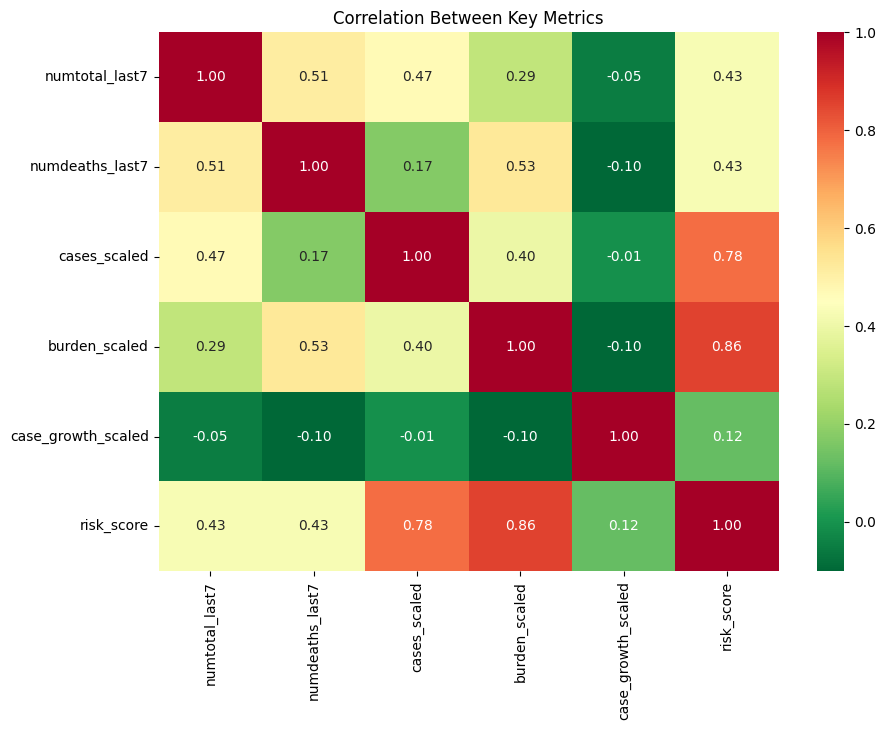

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = [
    "numtotal_last7", "numdeaths_last7",
    "cases_scaled", "burden_scaled",
    "case_growth_scaled", "risk_score"
]

corr = df_adv[num_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap="RdYlGn_r", fmt=".2f")
plt.title("Correlation Between Key Metrics")
plt.show()


In [33]:
from sklearn.cluster import KMeans

cluster_df = latest[["numtotal_last7", "numdeaths_last7", "risk_score"]].fillna(0)

kmeans = KMeans(n_clusters=3, random_state=42)
latest["cluster"] = kmeans.fit_predict(cluster_df)

fig = px.scatter(
    latest,
    x="numtotal_last7",
    y="risk_score",
    color="cluster",
    hover_name="prname",
    title="Province Clusters Based on Cases & Risk Score"
)

fig.show()
